Python Programming (2021-2022)[SEM1]

Project 2

Group 72

Dec.9, 2021

# Analysis of PM2.5 concentration in Beijing and its area

## I. Introduction

Air pollution is a phenomenon in which certain substances enter the atmosphere due to human activities or natural processes to significantly endanger human health when presenting a sufficient concentration. PM2.5, the invisible solid particles floating in the air, and one of the main air pollutants, is mainly sourced from the combustion of solid and liquid fuels, through power generation, domestic heating, and in-vehicle engines. Mainly, it causes adverse effects on human health. A large number of epidemiological studies have found that long-term exposure to high concentrations of PM2.5 will increase the morbidity and mortality of respiratory diseases and cardiovascular diseases.
In the past few years, Beijing's air pollution has always been a problem of great concern, especially in autumn and winter every year. Therefore, the people and government have attached great importance to air pollution in recent years and have taken many actions to improve air quality, especially the "Clean Air Action Plan" implemented by the Beijing Ministry of Environmental Protection from 2013 to 2017. Thus, this project intends to use some valuable plots to explore if the concentration of PM2.5 has gradually decreased after taking many measures to lower air pollution.

However, changes in the concentration of PM2.5 are not only dependent on people's actions but are also affected by many other aspects, such as weather, climate and etc. As we know, because air is almost always on the move, air pollution is easily transported from one area to another. Thus, the weather may also have a significant impact on air quality. For example, wind speed affects the diffusion and dilution of pollutants, and a higher temperature can accelerate these chemical reactions in the air, sunlight can cause chemical reactions of some pollutants, and so on. Therefore, in order to further explore the changes of PM2.5, we will also investigate the influence of weather conditions on PM2.5 by observing some significant plots, including the temperature, humidity, precipitation, snow depth, wind speed, wind direction, sunshine, sea-level air pressure and peak wind gust. In addition, because Hebei Province geographically surrounds Beijing, we are very interested in the changes in the concentration of PM2.5 in Hebei Province. We are curious whether the air quality in Hebei Province has also improved as the air quality in Beijing improves.

The data set used in this project is from the public source OpenAq and Meteostat, including the PM2.5 concentration and seven related meteorological variables' measurements during the time period from November 11, 2013, to Today. There are some missing values in the data set, and we prefer to use the value 0 to replace all missing data.

## II. Data

Firstly, we have to obtain all the measurements of PM2.5 concentration and the measurements of all relevant weather variables in Beijing during the period of November 2013 to today from two public resources, [OpenAq](https://openaq.org/#/) and [Meteostat](https://meteostat.net/en/), respectively. Then, the data need to be processed, including replacing missing values with median values, removing outliers, and perhaps normalizing data.

### 1. Measurments of PM2.5 concentration in Beijing

In [1]:
import seaborn as sns
import openaq
import pandas as pd
import numpy as np
import warnings
from tqdm import trange
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
api = openaq.OpenAQ(version='v2')
warnings.simplefilter('ignore')

In [2]:
# Lines 81: NA
# URL: https://easygui.readthedocs.io/en/latest/tutorial.html
# Accessed on 18 Nov 2021.

#The following is to filter data of Beijing's PM2.5 from OpenAq:

# Load a library for easy interaction
import easygui

# Filter Chinese cities
resp = api.cities(df = True, limit = 10000)
all_Ccity = resp.query("country == 'CN'")['city'].values

# Choose a city in China
Ccity_name = easygui.choicebox('Select a city','city choice',sorted(all_Ccity))

# Find this city’s data, as its location, pm2.5 value, date data and so on
Cc_location = api.locations(city = Ccity_name, parameter = 'pm25', df = True)['name'][0]
Cc_data = api.measurements(city = Ccity_name, parameter = 'pm25', limit = 100000, df = True)

# Split date data to facilitate group processing
Cc_date = [str(Cc_data['date.utc'][i])[:10] for i in range(len(Cc_data))]
Cc_hour = [int(str(Cc_data['date.utc'][i])[11:13]) for i in range(len(Cc_data))]
Cc_day = [int(str(Cc_data['date.utc'][i])[8:10]) for i in range(len(Cc_data))]
Cc_month = [int(str(Cc_data['date.utc'][i])[5:7]) for i in range(len(Cc_data))]
Cc_year = [int(str(Cc_data['date.utc'][i])[0:4]) for i in range(len(Cc_data))]

# Filter the columns of the data set to generate a new data set variables
new_data = Cc_data[['value','country','city','coordinates.latitude','coordinates.longitude']].reset_index(drop = True)
new_data['date'] = Cc_date
new_data['year'] = Cc_year
new_data['month'] = Cc_month
new_data['day'] = Cc_day
new_data['hour'] = Cc_hour
new_data['year-month'] = [i[:7] for i in np.array(new_data['date'])]
new_data = new_data.reset_index(drop = True)   # reverse order
new_data = new_data[new_data.value > 0]        # remove abnormal value whose value is less than 0

# Deal with outliers according to the 3sigma rule
new_data = new_data[(new_data.value<new_data['value'].mean()+3*new_data['value'].std()) & (new_data.value>new_data['value'].mean()-3*new_data['value'].std())]
# Sort the data in new_data
new_data = new_data.sort_values(by=['year','month','day','hour']).reset_index(drop=True)

In [3]:
# Get the information of new_data:
print(new_data.describe()['value'])
# Find the number of NaN in each column of new_data:
print('\n\nThe number of NaN of PM2.5 values is', new_data.isna().sum()['value'])

count    56777.000000
mean        51.812146
std         51.189561
min          1.000000
25%         15.000000
50%         35.000000
75%         70.000000
max        296.400000
Name: value, dtype: float64


The number of NaN of PM2.5 values is 0


In [4]:
# Here is the look of our new_data:
print('The final dataset with all PM2.5 concetration in Beijing: \n')
new_data.head(2)

The final dataset with all PM2.5 concetration in Beijing: 



,value,country,city,coordinates.latitude,coordinates.longitude,date,year,month,day,hour,year-month
0,30.0,CN,Beijing,40.01,116.333,2013-11-26,2013,11,26,8,2013-11
1,28.1,CN,Beijing,40.01,116.333,2013-11-26,2013,11,26,9,2013-11


### 2. Measurments of all relevant weather variables in Beijing

- This is the weather data description from meteostat：

|Column|Description|	Type|
|:--------|:--------|:--------|
|station|	The Meteostat ID )|String|
|time|	The date|	Datetime64|
|tavg|	The average air temperature in °C	|Float64|
|tmin|	The minimum air temperature in °C	|Float64|
|tmax|	The maximum air temperature in °C	|Float64|
|prcp|	The daily precipitation total in mm	|Float64|
|snow|	The snow depth in mm	|Float64|
|wdir|	The average wind direction in degrees (°)	|Float64|
|wspd|	The average wind speed in km/h	|Float64|
|wpgt|	The peak wind gust in km/h	|Float64|
|pres|	The average sea-level air pressure in hPa	|Float64|
|tsun|	The daily sunshine total in minutes (m)	|Float64|

In [5]:
# Lines 298-302: NA
# URL:https://dev.meteostat.net/python/daily.html#example
# Accessed on 20 Nov 2021.

#The following is to filter data of all relevant weather variables in Beijing from Meteostat:

# Getting station data
from meteostat import Stations
from datetime import datetime
from meteostat import Stations, Daily

# Get nearby weather stations
stations = Stations()
station = stations.fetch()
# Filter China City Data
city_id = station[station.country == 'CN' ][['name','wmo']]
city_id = np.array(city_id.dropna(axis=0,how='any'))

# Returns the id corresponding to the city name
city_id_dic = dict(city_id)
w_name = easygui.choicebox('Select a city','city choice',sorted(city_id_dic.keys()))
w_c_id = city_id_dic.get(w_name)

print('Station ID of',w_name,':',w_c_id)

Station ID of Beijing : 54511


In [6]:
# Set time period
end = datetime(int(new_data.loc[len(new_data)-1,'year']), int(new_data.loc[len(new_data)-1,'month']), int(new_data.loc[len(new_data)-1,'day']))
start = datetime(int(new_data.loc[0,'year']), int(new_data.loc[0,'month']), int(new_data.loc[0,'day']))
# Get daily data
# Because the hourly data is high frequency and that is too abundant so we prefer to get the daily data
weather_data = Daily(w_c_id, start, end)
# Use the normalize method to make sure that gaps in the time series are filled.
weather_data = weather_data.normalize()
weather_data = weather_data.fetch()
# Get the information of weather_data
weather_data.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,2936.000000,2905.000000,2898.000000,1713.000000,16.000000,1409.000000,2863.000000,0.0,1841.000000,0.0
mean,13.326567,7.673184,19.566805,2.786165,30.375000,179.132860,9.545861,NaN,1015.576915,NaN
std,11.250243,11.414531,11.324981,10.157628,21.731314,105.992129,4.441088,NaN,10.097380,NaN
min,-15.800000,-23.000000,-13.000000,0.000000,10.000000,0.200000,3.300000,NaN,994.900000,NaN
25%,2.600000,-3.000000,9.000000,0.000000,10.000000,96.700000,6.550000,NaN,1006.900000,NaN
50%,14.350000,8.500000,21.000000,0.000000,25.000000,157.200000,8.400000,NaN,1014.800000,NaN
75%,23.800000,18.000000,30.000000,1.000000,43.500000,289.300000,11.000000,NaN,1023.400000,NaN
max,32.800000,28.500000,42.000000,262.600000,71.000000,359.700000,30.600000,NaN,1044.000000,NaN


In [7]:
# Lines 598: NA
# URL：https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
# Accessed on 20 Nov 2021.

# Deal with weather data
weather_data = weather_data.reset_index() 
print('\nReset the index such that the time can be a column:\n')
weather_data.head(2)


Reset the index such that the time can be a column:



,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2013-11-26,1.4,-5.0,8.0,NaN,NaN,NaN,16.2,NaN,NaN,NaN
1,2013-11-27,-2.2,-4.1,0.0,NaN,NaN,325.5,28.2,NaN,NaN,NaN


In [8]:
# Split year, month and day in weather data
date = [str(weather_data['time'][i])[:10] for i in range(len(weather_data))]
day = [int(str(weather_data['time'][i])[8:10]) for i in range(len(weather_data))]
month = [int(str(weather_data['time'][i])[5:7]) for i in range(len(weather_data))]
year = [int(str(weather_data['time'][i])[0:4]) for i in range(len(weather_data))]

weather_data['date'] = date
weather_data['year'] = year
weather_data['month'] = month
weather_data['day'] = day
weather_data['year-month'] = [i[:7] for i in np.array(weather_data['date'])]

print('\nAfter adding the columns of date,year,month and day:\n')
weather_data.head(2)


After adding the columns of date,year,month and day:



,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,date,year,month,day,year-month
0,2013-11-26,1.4,-5.0,8.0,NaN,NaN,NaN,16.2,NaN,NaN,NaN,2013-11-26,2013,11,26,2013-11
1,2013-11-27,-2.2,-4.1,0.0,NaN,NaN,325.5,28.2,NaN,NaN,NaN,2013-11-27,2013,11,27,2013-11


In [9]:
# Find the number of NaN in each column of new_data:
print('The number of NaN of each weather variable is',weather_data.isna().sum())
print('\n\nThe proportion of NaN of each weather variable is', 100*weather_data.isna().sum()/(weather_data.shape[0]))

The number of NaN of each weather variable is time             0
tavg             0
tmin            31
tmax            38
prcp          1223
snow          2920
wdir          1527
wspd            73
wpgt          2936
pres          1095
tsun          2936
date             0
year             0
month            0
day              0
year-month       0
dtype: int64


The proportion of NaN of each weather variable is time            0.000000
tavg            0.000000
tmin            1.055858
tmax            1.294278
prcp           41.655313
snow           99.455041
wdir           52.009537
wspd            2.486376
wpgt          100.000000
pres           37.295640
tsun          100.000000
date            0.000000
year            0.000000
month           0.000000
day             0.000000
year-month      0.000000
dtype: float64


From the above output, we can see that the proportion of NaN values of variables snow, wpgt and tsun is so close to one hundred.<br>Hence, there is no significant influence if we drop these variables to investigate the weather effect on PM2.5 value.

In [10]:
# Drop variables snow, wpgt and tsun from weather_data
weather_data=weather_data.drop(columns=['snow', 'wpgt','tsun'])
# Fill NAN values of each column by 0:
weather_data=weather_data.fillna(0)

# Here is the look of our weather_data:
print('The final dataset with all significant weather variables in Beijing: \n')
weather_data.head()

The final dataset with all significant weather variables in Beijing: 



,time,tavg,tmin,tmax,prcp,wdir,wspd,pres,date,year,month,day,year-month
0,2013-11-26,1.4,-5.0,8.0,0.0,0.0,16.2,0.0,2013-11-26,2013,11,26,2013-11
1,2013-11-27,-2.2,-4.1,0.0,0.0,325.5,28.2,0.0,2013-11-27,2013,11,27,2013-11
2,2013-11-28,2.4,-4.4,6.1,0.0,300.2,20.0,0.0,2013-11-28,2013,11,28,2013-11
3,2013-11-29,5.2,-4.2,12.0,0.0,0.0,10.4,0.0,2013-11-29,2013,11,29,2013-11
4,2013-11-30,2.7,-1.4,11.0,0.0,0.0,8.9,0.0,2013-11-30,2013,11,30,2013-11


### 3. Combine the measurments of PM2.5 concentration and all relevant weather variables 

In [11]:
# Combine data
pm25_data_day = new_data.groupby('date').mean().reset_index()
wd = [str(i)[:10] for i in list(weather_data['time'].values)]
w_res = []
for i in range(len(pm25_data_day)):
    if pm25_data_day.iloc[i,0] in wd:
        ind = wd.index(pm25_data_day.iloc[i,0])
        w_res.append(list(weather_data.iloc[ind,:]))
    else:
        w_res.append(['non'] * 11)

wdf = pd.DataFrame(w_res,columns=weather_data.columns)
pm_wh_df = pd.concat([pm25_data_day,wdf],axis = 1).iloc[:,[0,4,5,6,7,1,9,10,11,12,13,14,15,20]]
# Change year's type:
pm_wh_df['year'] = pm_wh_df['year'].astype(int)

# Here is our combined data:
print('The dataset after combining the measurments of PM2.5 concentration and all relevant weather variables in Beijing: \n')
pm_wh_df.head(2)

The dataset after combining the measurments of PM2.5 concentration and all relevant weather variables in Beijing: 



,date,year,month,day,hour,value,tavg,tmin,tmax,prcp,wdir,wspd,pres,year-month
0,2013-11-26,2013,11.0,26.0,15.5,16.568750,1.4,-5.0,8.0,0.0,0.0,16.2,0.0,2013-11
1,2013-11-27,2013,11.0,27.0,11.5,14.345833,-2.2,-4.1,0.0,0.0,325.5,28.2,0.0,2013-11


## III.  Plot

### 1. Time series graphs of PM2.5 concentration in Beijing

Once we have already read in data and made some improvements to our dataset, the first plot is usually a simple visualization to get a feel of the data. Therefore, first of all, we should construct some time-series graphs of the data of PM2.5 concentration in Beijing, and inspect the graphs for any unusual observations. Then, we start by observing the data characteristics in the graphs.

Since the hourly data is so high frequency such that it is difficult to get valuable information if we draw plots by hourly data, we choose to aggregate the hourly data to monthly data and then draw a simple time series plot of PM2.5 concentration in Beijing from Nov 2013 to Today.

There are no significant outliers in the following time series plot and any sudden shifts. By just eyeballing this plot, we can get a lot of information. First of all, we can see that the annual peak of PM2.5 concentration is gradually lower. It can be observed that, in general, there is a remarkable downward movement trend in the entire data, as well as no apparent cyclic. In addition, the data reveal strong seasonality within each year. Basically, the content of PM2.5 every summer always drops, and it exactly has a significant increase in autumn and winter. Moreover, one thing that needs our attention is that the seasonal pattern does not change with time increasing; the seasonal changes of each year are almost identical. 

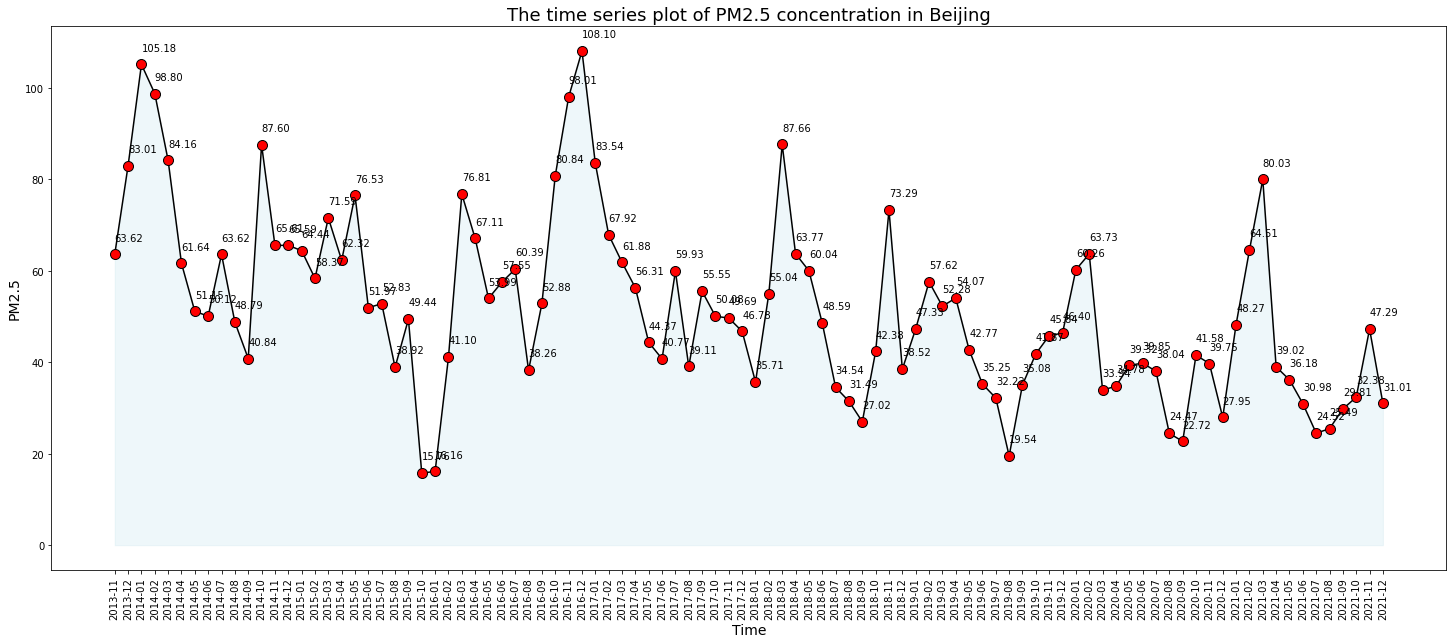

In [12]:
def year_month_change(data):
    ''' 
    Return the mean value by year-month and plot the change of year-month average PM2.5 in this city
    '''
    %matplotlib inline
    # Calculate the mean value by year-month
    year_month_data = data.groupby(['year-month']).mean()
    
    # Plot the year-month change of PM25
    plt.figure(figsize = (25,10))
    plt.plot(range(len(year_month_data)),year_month_data['value'],color='black',marker='o',markerfacecolor='red',markersize=10)
    plt.fill_between(range(len(year_month_data)),0,year_month_data['value'],color='lightblue',alpha=0.2)
    plt.xticks(range(len(year_month_data)),year_month_data.index,rotation = 90)
    for i in range(len(year_month_data)):
        plt.text(x = i,y = year_month_data.iloc[i,0]+3,s = '%.2f'%year_month_data.iloc[i,0])
    plt.xlabel('Time',fontsize = 14)
    plt.ylabel('PM2.5',fontsize = 14)
    plt.title(f'The time series plot of PM2.5 concentration in {Ccity_name}',fontsize = 18)
    plt.show()

# Get the simple time series plot of PM2.5 concentration in Beijing from Nov,2013 to Today
year_month_change(new_data)

Through a simple time-series graph, we have a rough understanding of the trend and other changes of PM2.5 concentration over this period. However, we would like to explore the pattern of annual changes of PM2.5 concentration. Therefore, we aggregate these data into annual data, and it is easier to see whether PM2.5 concentration decreases year by year.

In the following barplot of annual average PM2.5 concentration in Beijing, it is apparent that there is a significant upward trend only in the period from 2015 to 2016 and a slight increase from 2020 to 2021. However, the value of PM2.5 concentration generally shows an evident downward trend. In particular, in the past few years, the PM2.5 concentration has been reduced by almost $50 \%$.

Besides, we are trying to use a standardized way of displaying the distribution of PM2.5 concentration based on some summary statistics, and then we draw a boxplot of the annual average pm2.5 distribution. The following boxplot shows that the maximum annual PM2.5 concentration tends to decrease year by year, except for 2016, which shows a slight upward trend. However, the median annual PM2.5 concentration hardly changed. In addition, the boxplot is also getting shorter gradually, which suggests that overall PM2.5 concentration has a lower level. This information is consistent with the results we obtained from the previous two plots.

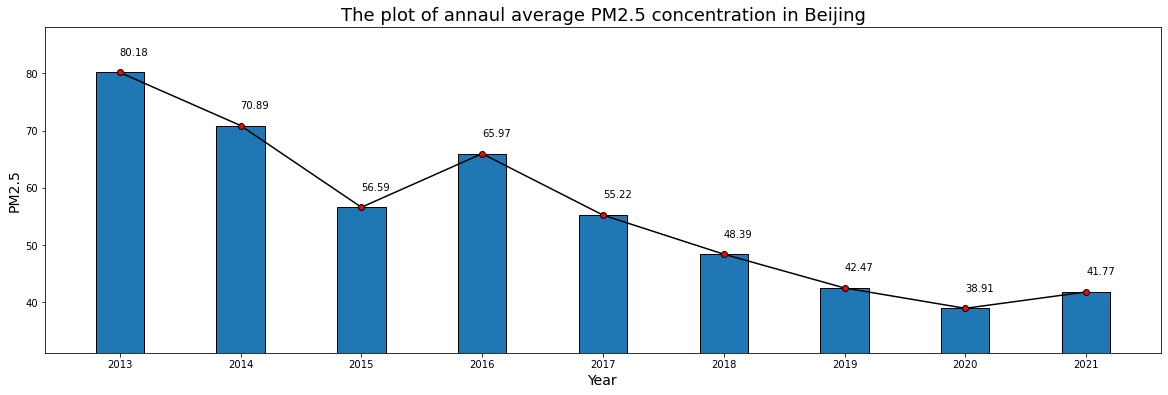

In [13]:
def year_change_plot(data):
    ''' 
    Return the mean value by year and plot the change of year average PM2.5 in this city
    '''
    # Calculate the mean value by month
    year_data = data.groupby('year').mean().reset_index()
    
    # Plot the yearly change of PM25
    fontsize = 14
    plt.figure(figsize = (20,6))
    plt.plot(range(len(year_data)),year_data['value'],color='black',marker='o',markerfacecolor='red',markersize=6)
    plt.bar(range(len(year_data)),year_data['value'],width=0.4,edgecolor='black')
    plt.xticks(range(len(year_data)),year_data['year'])
    for i in range(len(year_data)):
        plt.text(x = i,y = year_data.iloc[i,1]+3,s = '%.2f'%year_data.iloc[i,1])
    plt.xlabel('Year',fontsize = fontsize)
    plt.ylabel('PM2.5',fontsize = fontsize)
    plt.ylim(bottom = year_data['value'].min()*0.8,top = year_data['value'].max()*1.1)
    plt.title(f'The plot of annaul average PM2.5 concentration in {Ccity_name}',fontsize = 18)
    plt.show()

# Get the barplot of annual PM2.5 concentration in Beijing from Nov,2013 to Today
year_change_plot(new_data)

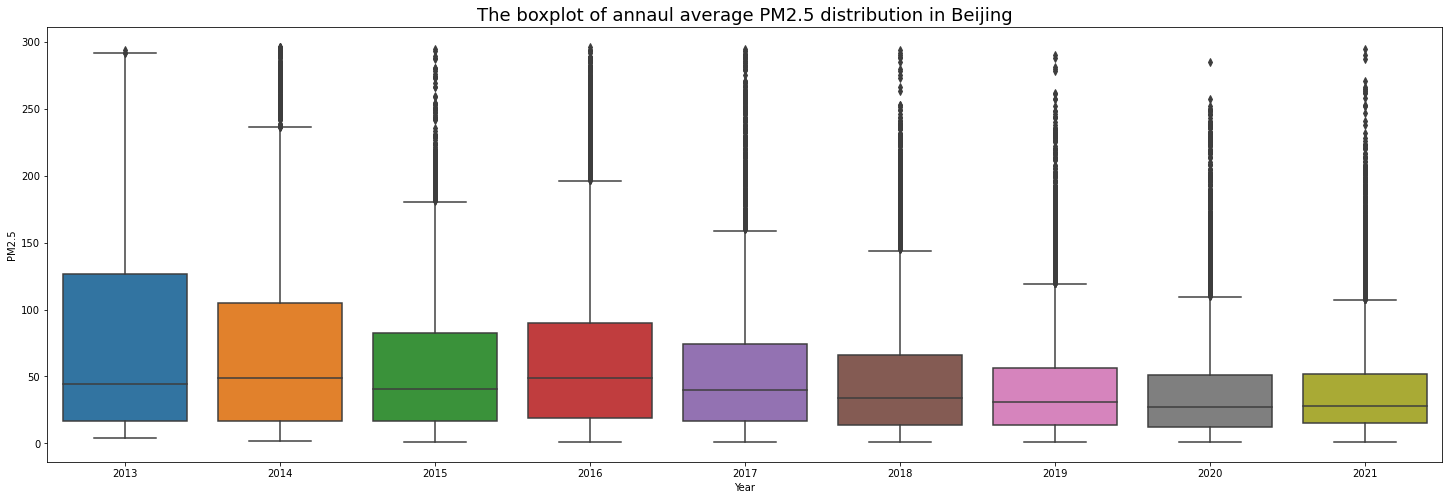

In [14]:
# Lines 1241: NA
# URL:https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Accessed on 26 Nov 2021.

# Plot a box plot of the yearly average pm2.5 distribution change in this city

plt.figure(figsize = (25,8))
sns.boxplot(y = 'value',x = 'year',data = new_data)
plt.xlabel('Year')
plt.ylabel('PM2.5')
plt.title(f'The boxplot of annaul average PM2.5 distribution in {Ccity_name}',fontsize = 18)

plt.show()

In the previous time series plot of PM2.5 in Beijing, we detect that the data exists the seasonality. Hence, we draw a seasonal plot to explore more about it. A seasonal plot allows the underlying seasonal pattern to be seen more clearly, and is especially useful in identifying years in which the pattern changes. Therefore, from the following two plots, the barplot and the polar plot, it can be observed that from June to September, the PM2.5 concentration presents a very obvious lower level; from November to March of the following year, the PM2.5 concentration shows a very higher level. In particular, the PM2.5 concentration in March is almost twice that in August. Besides, we can further understand the seasonality of each year from the below small multiple time series plot.

At the same time, the displaying distribution of monthly PM2.5 concentration in the below boxplot also verified our findings. The box in August is the shortest, which means that the overall PM2.5 concentration in August has a lower level. The box in March is the longest, which means that the overall PM2.5 concentration in March has a higher level.

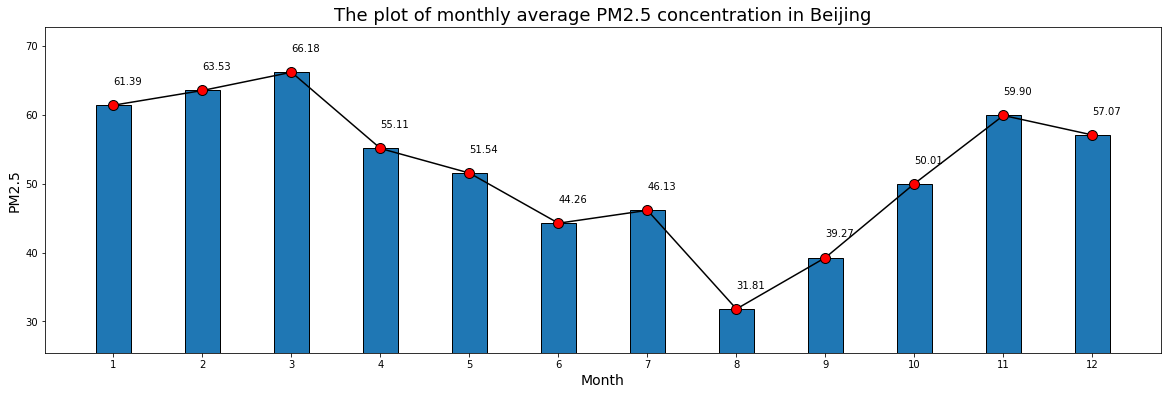

In [15]:
def month_change_plot(data):
    ''' 
    Return the mean value by moth and plot the change of month average PM2.5 in this city
    '''
    %matplotlib inline
    # Calculate the mean value by month
    month_data = data.groupby('month').mean().reset_index()
    
    # Plot the monthly change of PM25
    plt.figure(figsize = (20,6))
    plt.plot(range(len(month_data)),month_data['value'],color='black',marker='o',markerfacecolor='red',markersize=10)
    plt.bar(range(len(month_data)),month_data['value'],width=0.4,edgecolor='black')
    plt.xticks(range(len(month_data)),month_data['month'])
    for i in range(len(month_data)):
        plt.text(x = i,y = month_data.iloc[i,1]+3,s = '%.2f'%month_data.iloc[i,1])
    plt.xlabel('Month',fontsize = 14)
    plt.ylabel('PM2.5',fontsize = 14)
    plt.ylim(bottom = month_data['value'].min()*0.8,top = month_data['value'].max()*1.1)
    plt.title(f'The plot of monthly average PM2.5 concentration in {Ccity_name}',fontsize = 18)
    plt.show()
    
month_change_plot(new_data)

In [16]:
# Lines 1553-1554: Michael
# URL:https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
# Accessed on 26 Nov 2021.

# Convert the month int into month name
pm_wh_df2 = pm_wh_df.groupby('year-month').mean().reset_index(drop=True).sort_values(['year','month','day'])
pm_wh_df2['month'] = pd.to_datetime(pm_wh_df2['month'], format='%m').dt.month_name().str.slice(stop=3)
pm_wh_df2.head()
# new_dataa = new_data[['value','year','month']]
# new_dataa['month'] = pd.to_datetime(new_dataa['month'], format='%m').dt.month_name().str.slice(stop=3)
# new_dataa

,year,month,day,hour,value,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013,Nov,28.000000,12.300000,60.487083,1.900000,-3.820000,7.420000,0.000000,125.140000,16.740000,0.0
1,2013,Dec,16.000000,10.624920,95.067925,-0.112903,-5.929032,5.606452,0.000000,33.441935,10.661290,0.0
2,2014,Jan,11.909091,10.470471,111.766066,-1.195455,-5.890909,4.450000,0.000000,15.577273,7.772727,0.0
3,2014,Feb,14.500000,11.807268,100.695690,-0.664286,-4.478571,3.660714,0.217857,18.307143,8.139286,0.0
4,2014,Mar,9.769231,11.512443,82.358350,5.915385,-0.384615,11.769231,0.076923,26.400000,9.923077,0.0


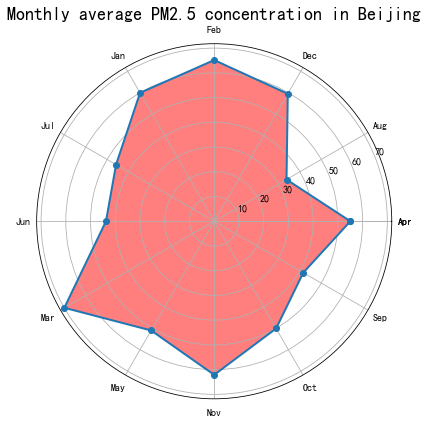

In [17]:
# Lines 1593-1610: NA
# URL: https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_demo.html
# Accessed on 29 Nov 2021.

# Get a polar seasonal plot:

# Construct data
month_data = pm_wh_df2.groupby('month').mean().reset_index()
values = list(month_data['value'])
feature = list(month_data['month'])
feature = np.concatenate((feature,[feature[0]]))

# Sets the Angle of the radar diagram, used to bisect a plane
N = len(values)
angles = np.linspace(0,2*np.pi,N,endpoint=False)
plt.rcParams['font.sans-serif'] = 'simhei'

# Enclose off the radar diagram
values = np.concatenate((values,[values[0]]))
angles = np.concatenate((angles,[angles[0]]))

# Plot a radar diagram
fig = plt.figure(figsize=(14,8))
# Set to polar coordinate format
ax = fig.add_subplot(121, polar=True)
# Draw a line chart in radar diagram
ax.plot(angles,values,'o-',linewidth=2,label='city')
ax.fill(angles,values,'r',alpha=0.5)
ax.set_thetagrids(angles*180/np.pi,feature)
plt.title(f'Monthly average PM2.5 concentration in {Ccity_name}',fontsize = 18)  # add title
ax.grid(True)                                                                    # add grid paper

plt.show()

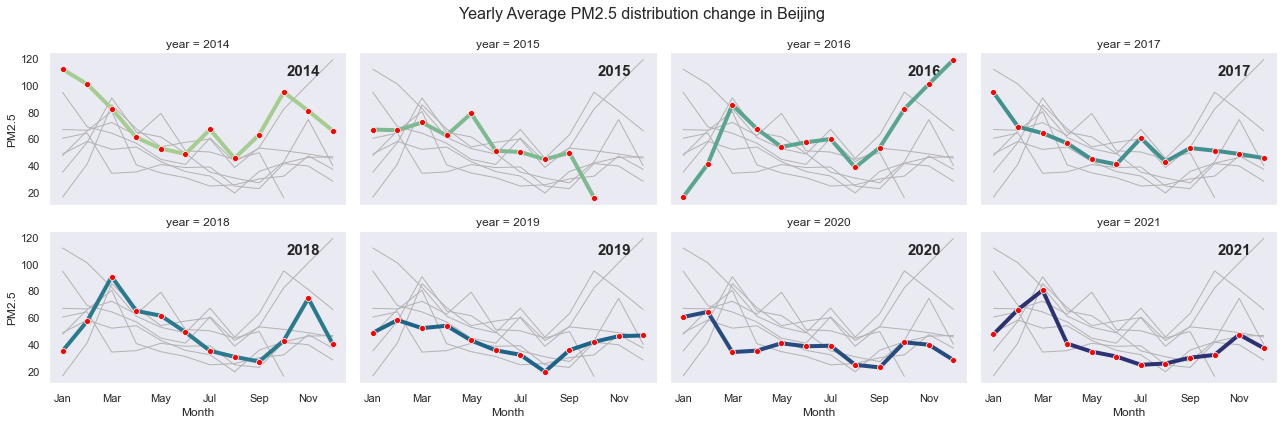

In [18]:
# Lines 1640-1668: NA
# URL: https://seaborn.pydata.org/examples/timeseries_facets.html
# Accessed on 29 Nov 2021.

# Plot each year's time series in its own facet
# The following is to draw a small multiple time series plot:
sns.set_theme(style = "dark")
pm_wh_df3 = pm_wh_df2.drop([0,1])
g1 = sns.relplot(
    data = pm_wh_df3,
    x="month", y="value", col="year", hue="year",
    kind="line",palette="crest",linewidth=4, zorder=5,
    marker='o',markerfacecolor='red',
    col_wrap=4, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g1.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold",size=15)

    # Plot every year's time series in the background
    sns.lineplot(
        data=pm_wh_df3, x="month", y="value", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    
# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

plt.subplots_adjust(top = 0.9)
plt.suptitle(f'Yearly Average PM2.5 distribution change in {w_name}',fontsize = 16)

# Tweak the supporting aspects of the plot
g1.set_axis_labels("Month", "PM2.5")
g1.tight_layout()

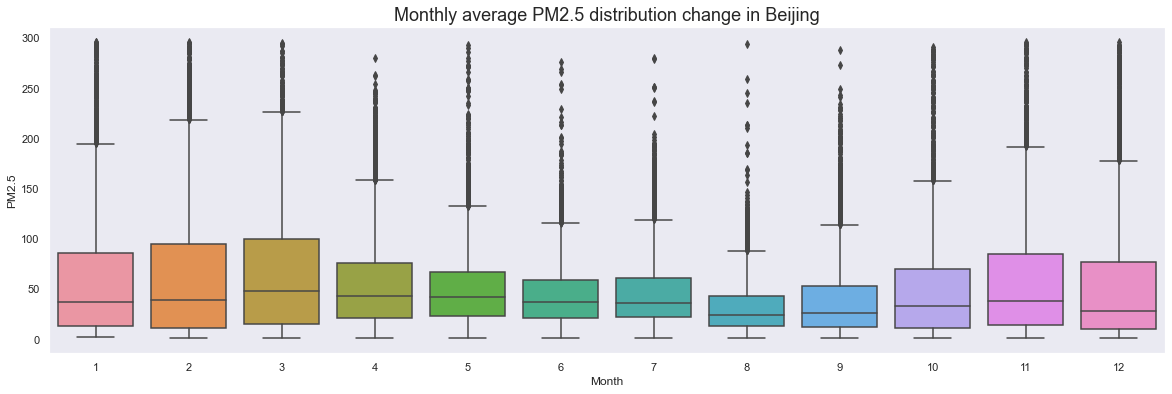

In [19]:
# Plot the monthly average pm2.5 distribution change in this city
plt.figure(figsize = (20,6))
sns.boxplot(y = 'value',x = 'month',data = new_data)
plt.xlabel('Month')
plt.ylabel('PM2.5')
plt.title(f'Monthly average PM2.5 distribution change in {Ccity_name}',fontsize = 18)
plt.show()

The plot above shows the monthly average PM2.5 distribution of Beijing. The distribution of PM2.5 pollutants is less during summer months such as June, July, and August. After September, there was a sudden increase in PM2.5 distribution. Winter in China is very chilly. Therefore to keep warm, people in china always use wood to burn to take the heat. Similarly, it is observed from the graph that citizens in Beijing always burn a huge amount of coal for heating every winter and therefore, pollution could increase dramatically, increasing the distribution of PM2.5 in November, December, January, and February Month.

### 2. Graphs to explore the influence of weather conditions on PM2.5

Afterwards, we first choose to use Pearson's correlation coefficient as the test statistic to measure the association between all weather variables in the dataset and the concentration of PM2.5. Then, we select weather variables that have a certain correlation with the PM2.5 concentration according to the coefficient value.

The following diagonal correlation matrix of weather conditions and PM2.5 concentration gives us all correlation coefficient values. According to the cut-off of the degree of correlation, we find that the absolute values of the correlation coefficients between all weather variables and PM2.5 concentration are less than 0.5, which means that no weather variable has a strong correlation with the PM2.5 concentration. In addition, only the absolute value of the correlation coefficient of wdir(The average wind direction) and wspt(the average wind speed) is greater than 0.3, which implies that both of them have a medium correlation with the PM2.5 concentration. So, we will only select these two weather variables，the average wind direction in degree and the average wind speed in km/h，to study their influence on PM2.5 concentration, and we will not spend time studying other weather variables.

In [20]:
# Select the data from pm_wh_df:
digit_df = pm_wh_df.iloc[:,[5,6,7,8,9,10,11,12]]
digit_df.head(2)

,value,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,16.568750,1.4,-5.0,8.0,0.0,0.0,16.2,0.0
1,14.345833,-2.2,-4.1,0.0,0.0,325.5,28.2,0.0


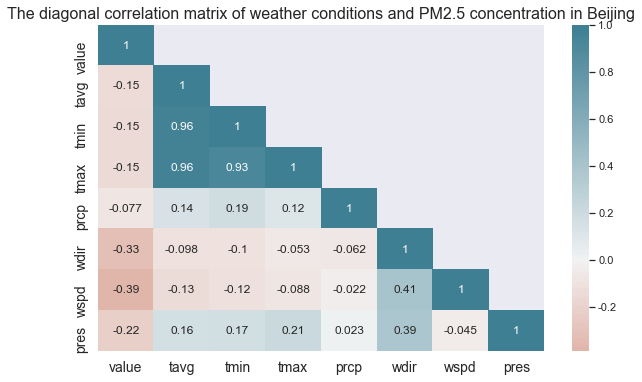

In [21]:
# Lines 1816-1827: NA
# URL: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Accessed on 29 Nov 2021.

# Correlation analysis

# Plot the heat map of weather and pollution
plt.figure(figsize = (10,6))
mask = []
len_dc = len(digit_df.columns)
mask = np.ones((len_dc,len_dc))
mask = np.triu(mask,k=1)
plt.rcParams['axes.unicode_minus'] = False
sns.heatmap(digit_df.corr(),
            cmap = sns.diverging_palette(20, 220, n = 200), 
            mask = mask,   # the data is displayed in the cell where the mask is False
            annot = True,  # import data
            center = 0)    # plot the value to center the color map when the data is colored
plt.title(f'The diagonal correlation matrix of weather conditions and PM2.5 concentration in {w_name}', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [22]:
# Choose wdir(The average wind direction) and wspt(the average wind speed)
digit_df=digit_df[['value','wdir','wspd']]

<Figure size 1080x576 with 0 Axes>

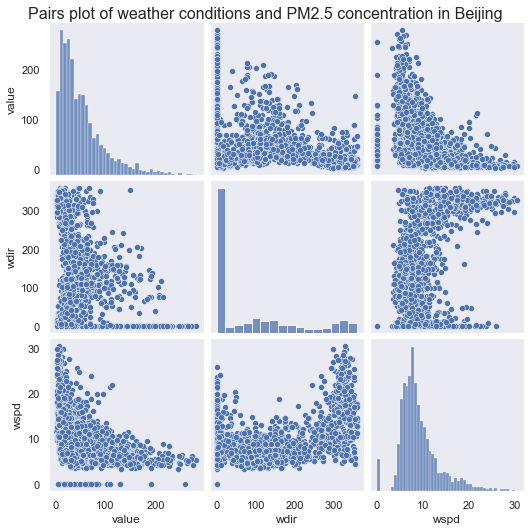

In [23]:
# Plot the pairs plot of weather and pollution
plt.figure(figsize = (15,8))
sns.pairplot(digit_df,palette = 'Set2')
plt.subplots_adjust(top = 0.95)
plt.suptitle(f'Pairs plot of weather conditions and PM2.5 concentration in {w_name}', fontsize = 16)

plt.show()

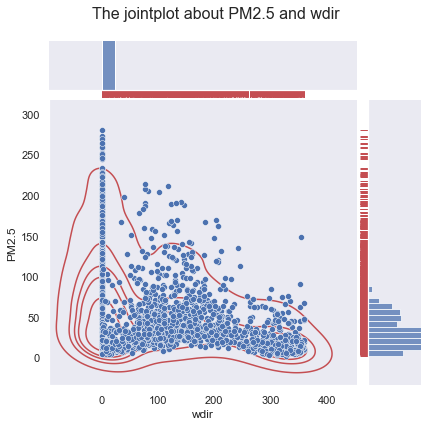

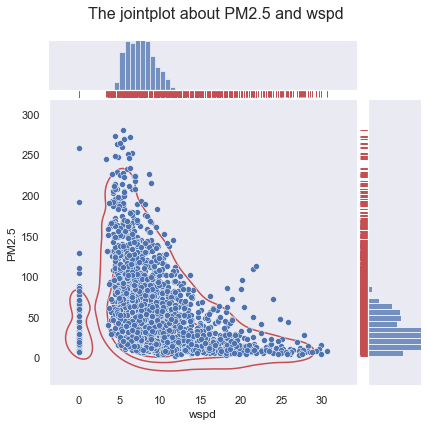

In [24]:
# Lines 1924-1925: Taras
# URL:https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot
# Accessed on 03 Dec 2021.

%matplotlib inline

# Choose wdir(The average wind direction) and wspt(the average wind speed)
x = ['wdir','wspd']

for i in range(2):
    # Plot the jointplot about pm2.5 and weather
    p = sns.jointplot(data = digit_df,x = x[i],y = "value",palette = 'spring')
    p.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)  
    p.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    p.ax_joint.set_xlabel(x[i],fontsize = 12)
    p.ax_joint.set_ylabel('PM2.5',fontsize = 12)
    p.fig.subplots_adjust(top = 0.9)   # adjust the Figure in rp
    p.fig.suptitle(f'The jointplot about PM2.5 and {x[i]}',fontsize = 16)

From the bove paris plot and joint plot, we can probably observe that in the plots of wspt vs. PM2.5, basically, as the value of wspd increases, the concentration of PM2.5 will decrease. However, the plots clearly show that this relationship is not linear. Furthermore, in the plots of wdir vs. PM2.5, because a large amount of data is concentrated in the lower area of the PM2.5 value, we cannot be confident to say that there is a decreasing relationship between wdir and PM2.5. 

In order to further study the relationship between the average wind direction and the average wind speed and PM2.5 concentration, we will use line plots to show their change over time, and therefore help us find some useful information, like trends, patterns and relationships between them.

From the two lineplots below, we can observe that the value of wspd hardly changes in the entire time period, which shows a horizontal straight line. However, there is a negative correlation relationship between wdir and PM2.5 concentration. Generally, when the value of wdir decreases, the PM2.5 concentration will increase. When the value of wdir increases, the PM2.5 concentration will decrease. This change was clearly demonstrated in the first line plot. The information displayed by the barplot and bubble plot below also supports our view.

<AxesSubplot:xlabel='Year', ylabel='PM2.5'>

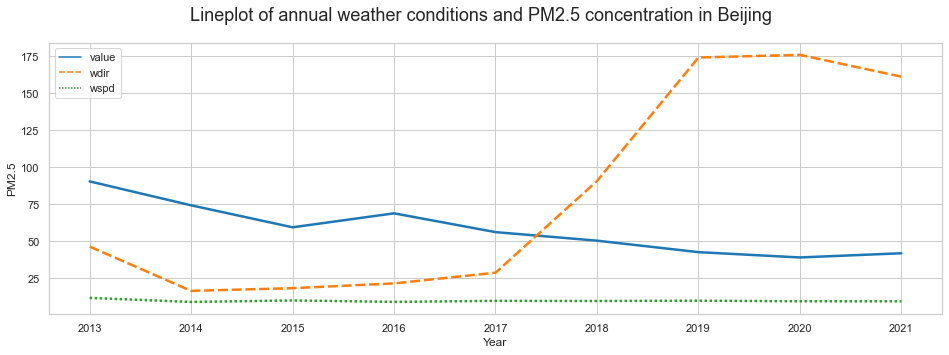

In [25]:
pm_wh_df_2=pm_wh_df.drop(columns=['tavg', 'tmin','tmax','prcp','pres','date', 'month','day','hour'])

digit_df_year=pm_wh_df_2.groupby('year').mean().reset_index()
digit_df_year=digit_df_year.set_index(digit_df_year.columns[0])
digit_df_year.head()
plt.figure(figsize=(16,5))
sns.set_theme(style="whitegrid")
plt.xlabel('Year')
plt.ylabel('PM2.5')

plt.suptitle(f'Lineplot of annual weather conditions and PM2.5 concentration in {w_name}', fontsize = 18)
sns.lineplot(data=digit_df_year, palette="tab10", linewidth=2.5)

<AxesSubplot:title={'center':'Lineplot of weather conditions and PM2.5 concentration in Beijing'}, xlabel='Time', ylabel='PM2.5'>

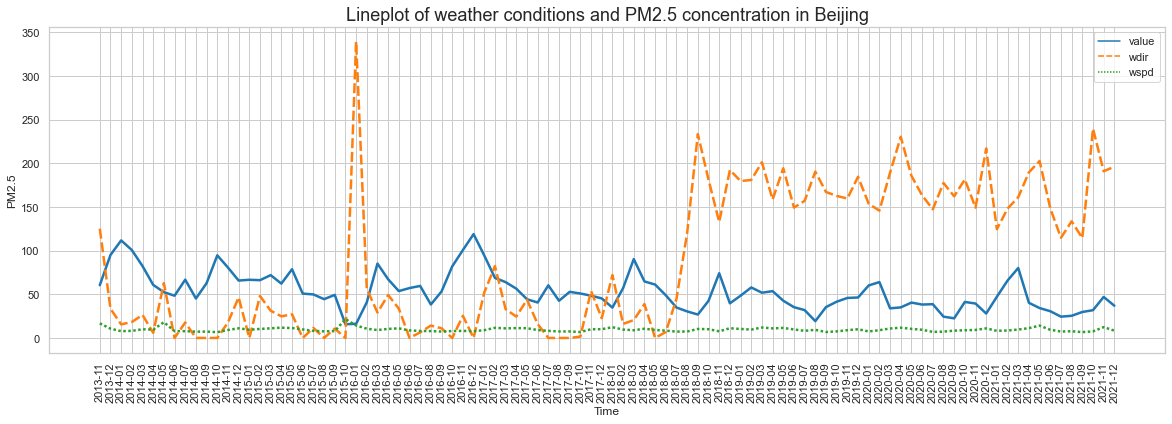

In [26]:
# Lines 2024-2025: NA
# URL: https://seaborn.pydata.org/examples/wide_data_lineplot.html
# Accessed on 01 Dec 2021.

# Reset the dataset to draw the lineplot

digit_df_month=pm_wh_df_2.groupby('year-month').mean().reset_index()
digit_df_month=digit_df_month.drop(columns=['year']).set_index(digit_df_month.columns[0])
digit_df_month.head()
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.title(f'Lineplot of weather conditions and PM2.5 concentration in {w_name}', fontsize = 18)

sns.set_theme(style="whitegrid")
sns.lineplot(data=digit_df_month, palette="tab10", linewidth=2.5)


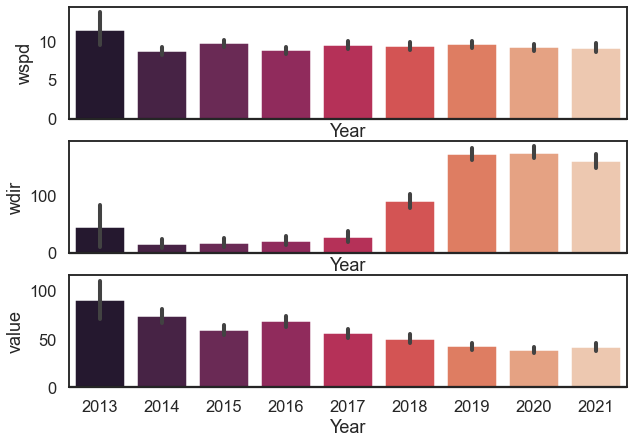

In [27]:
# Lines 2053-2056: NA
# URL:https://seaborn.pydata.org/examples/palette_choices.html
# Accessed on 01 Dec 2021.
l=['wspd','wdir','value']
sns.set_theme(style="white", context="talk")
# Set up the matplotlib figure
f, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
for i in range(3):
    sns.barplot(y=l[i], x='year',data=pm_wh_df,palette="rocket", ax=ax[i])
    ax[i].axhline(0, color="k", clip_on=False)
    ax[i].set_ylabel(l[i])
    ax[i].set_xlabel("Year")

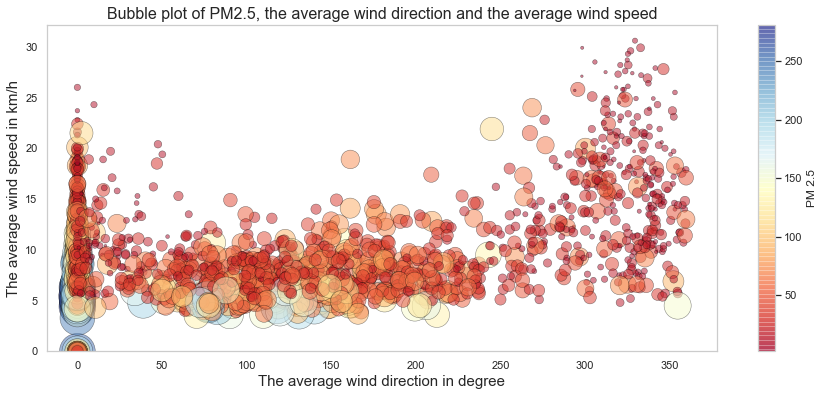

In [28]:
# Lines 2087-2094: NA
# URL：https://seaborn.pydata.org/examples/scatter_bubbles.html
# Accessed on 01 Dec 2021.

# Plot the bubble plot to show the relationship between PM2.5, average temperature and wind speed in Beijing
sns.set(style = "whitegrid")   # set style
x = list(pm_wh_df['wdir'])     # X-axis data
y = list(pm_wh_df['wspd'])     # Y-axis data
z = list(pm_wh_df['value'])    # z is used to resize each point
cm = plt.cm.get_cmap('RdYlBu')
fig,ax = plt.subplots(figsize = (15,6))
bubble = ax.scatter(x, y , s = (z - np.min(z) + 0.1) * 5, c = z,edgecolors = 'black', cmap = cm, linewidth = 0.5, alpha = 0.5)
ax.grid()
fig.colorbar(bubble,label = 'PM 2.5')
ax.set_xlabel('The average wind direction in degree', fontsize = 15) # X-axis label
ax.set_ylabel('The average wind speed in km/h', fontsize = 15) # Y-axis label
ax.set_ylim(min(y) * 0.9,max(y) * 1.05)
plt.title("Bubble plot of PM2.5, the average wind direction and the average wind speed",fontsize = 16)
plt.show()

### 3. Maps to explore the PM2.5 pollution in Hebei Province
In addition, because Hebei Province geographically surrounds Beijing, we are very interested in the changes in the concentration of PM2.5 in Hebei Province. We are curious whether the air quality in Hebei Province has also improved as the air quality in Beijing improves. Hence, we visualize the levels of air pollution in Hebei Province on a map. 

In [29]:
# Data acquisition of PM2.5 in various cities of Hebei Province, China

import openaq
import easygui
from tqdm import trange
api = openaq.OpenAQ(version = 'v2')
resp = api.cities(df = True, limit = 10000)
all_city = resp.query("country == 'CN'")['city'].values
data_list = []
prov_city = ['Beijing','石家庄市','唐山市','秦皇岛市','邯郸市','邢台市','保定市', '张家口市', '承德市', '沧州市', '廊坊市', '衡水市']

find_city = prov_city
for i in trange(len(find_city)):
    try:
        name = find_city[i]
        print(name)
        # Find each city's data
        location = api.locations(city=name, parameter='pm25', df=True)['name'][0]
        temp_data = api.measurements(city=name,date_from='2014-1-1',date_to='2021-1-1',parameter='pm25', limit=100000, df=True)[['city','value','date.utc']]
        temp_data = temp_data.reset_index(drop=True)                                                                              
        date = [str(temp_data['date.utc'][i])[:10] for i in range(len(temp_data))]
        hour = [int(str(temp_data['date.utc'][i])[11:13]) for i in range(len(temp_data))]
        day = [int(str(temp_data['date.utc'][i])[8:10]) for i in range(len(temp_data))]
        month = [int(str(temp_data['date.utc'][i])[5:7]) for i in range(len(temp_data))]
        year = [int(str(temp_data['date.utc'][i])[0:4]) for i in range(len(temp_data))]
        temp_data['year-month'] = [str(i)[:7] for i in np.array(temp_data['date.utc'])]
        temp_data['date'] = date
        temp_data['year'] = year
        temp_data['month'] = month
        temp_data['day'] = day
        temp_data['hour'] = hour
        temp_data = temp_data.groupby('year-month').mean().reset_index(drop = True)
        temp_data['city'] = [name] * len(temp_data)
        data_list.append(temp_data)
    except Exception as e:                     # exception can include all exceptions; Assign the exception to the variable e
        print(name,"----error----" + str(e))   # turn the exception into a string

  0%|          | 0/12 [00:00<?, ?it/s]

Beijing


  8%|▊         | 1/12 [00:16<03:00, 16.37s/it]

石家庄市


 17%|█▋        | 2/12 [01:20<07:24, 44.42s/it]

唐山市


 25%|██▌       | 3/12 [01:44<05:15, 35.09s/it]

秦皇岛市


 33%|███▎      | 4/12 [02:10<04:12, 31.55s/it]

邯郸市


 42%|████▏     | 5/12 [02:32<03:16, 28.14s/it]

邢台市


 50%|█████     | 6/12 [02:58<02:43, 27.24s/it]

保定市


 58%|█████▊    | 7/12 [03:22<02:10, 26.16s/it]

张家口市


 67%|██████▋   | 8/12 [03:46<01:42, 25.52s/it]

承德市


 75%|███████▌  | 9/12 [04:11<01:16, 25.48s/it]

沧州市


 83%|████████▎ | 10/12 [04:30<00:46, 23.40s/it]

廊坊市


 92%|█████████▏| 11/12 [04:53<00:23, 23.23s/it]

衡水市


100%|██████████| 12/12 [05:12<00:00, 26.05s/it]


In [30]:
import pandas as pd
together_data=pd.concat([data_list[0],data_list[1]])
for i in range(2,len(data_list)):
    together_data=pd.concat([together_data,data_list[i]])
together_data['year-month']=[str(int(together_data.iloc[i,1])) + '-'+ str(int(together_data.iloc[i,2])) for i in range(len(together_data))]

together_data

,value,year,month,day,hour,city,year-month
0,146.122134,2014.0,1.0,11.523715,11.420949,Beijing,2014-1
1,115.846841,2014.0,2.0,14.718028,11.334361,Beijing,2014-2
2,108.543165,2014.0,3.0,8.568345,11.370504,Beijing,2014-3
3,61.641353,2014.0,4.0,15.756391,11.261654,Beijing,2014-4
4,51.146667,2014.0,5.0,9.346667,10.626667,Beijing,2014-5
...,...,...,...,...,...,...,...
23,28.997567,2020.0,9.0,15.580535,11.449635,衡水市,2020-9
24,41.465816,2020.0,10.0,15.630102,11.545408,衡水市,2020-10
25,46.073419,2020.0,11.0,15.184887,11.487138,衡水市,2020-11
26,67.158684,2020.0,12.0,16.208309,11.285055,衡水市,2020-12


In [31]:
# Lines 2544-2545: 其实还好啦
# URL: https://blog.csdn.net/qq_46614154/article/details/106255835
# Accessed on 05 Dec 2021.

# Visualization based on the acquired data
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.render import make_snapshot
prov_city = ['Beijing','石家庄市','唐山市','秦皇岛市','邯郸市','邢台市','保定市', '张家口市', '承德市', '沧州市', '廊坊市', '衡水市']
eng_name=['Beijing','Shijiazhuang','Tangshan','Qinhuangdao','Handan','Xingtai','Baoding','Zhangjiakou','Chengde','Cangzhou','Langfang','Hengshui']
together_data=together_data[together_data.city != 'Beijing']
namemap = {}
# Generate map of Hebei Province in English name
for i in range(len(prov_city)):
    namemap.update({prov_city[i]:eng_name[i]})

In [32]:
# Lines 2776-2788: Vincent Lonij
# URL：https://blog.prototypr.io/interactive-maps-in-python-part-3-29f14a9b2f7d
# Accessed on 05 Dec 2021.

# Plot a map of the PM2.5 values of various cities in Hebei Province in 2019
%matplotlib inline
year = sorted(together_data.value_counts('year').index)
together_data_year = together_data[together_data['year'] == float(2019.0)]
data_y_prov_city = []
for i in range(len(eng_name)):
    city_data = dict(np.array(together_data_year[['city','value']]))
    data_y_prov_city.append([eng_name[i],city_data.get(prov_city[i],0)])

map = Map() 
map.add("", data_y_prov_city, "河北",name_map = namemap) 
map.set_global_opts(
        title_opts = opts.TitleOpts(title = "PM2.5 of Hebei Provinve in 2019"),
    visualmap_opts = opts.VisualMapOpts(
        min_ = 0,
        max_ = together_data_year['value'].max(),
        is_piecewise = True
    ))

# map.render(path="PM2.5 of Hebei Provinve in 2019.html")

map.render_notebook()

The above Map of Hebei of 2019 shows the spatial distribution of the PM2.5 concentrations in Beijing this year. The PM2.5 concentration Handan districts were the highest (92.7 μg/cm3) among all districts; The lowest concentration observed in the Zhangjiakou district was 30.4 μg/cm3. Those in Hengshui, Xingtai, Shijiazhuang, Cangzhou and Baoding districts were between 64 and 80 μg/cm3. A decreasing trend in PM2.5 concentrations was observed from south to north: there was more PM2.5 severe pollution in the south and better air quality in northern regions.

In [33]:
# Plot a map of the PM2.5 values of various cities in Hebei Province in 2020

%matplotlib inline
year = sorted(together_data.value_counts('year').index)
together_data_year = together_data[together_data['year'] == float(2020.0)]
data_y_prov_city = []
for i in range(len(eng_name)):
    city_data = dict(np.array(together_data_year[['city','value']]))
    data_y_prov_city.append([eng_name[i],city_data.get(prov_city[i],0)])

map = Map() 
map.add("", data_y_prov_city, "河北",name_map = namemap) 
map.set_global_opts(
    title_opts = opts.TitleOpts(title = "PM2.5 of Hebei Provinve in 2020"),
    visualmap_opts = opts.VisualMapOpts(
        min_ = 0,
        max_ = together_data_year['value'].max(),
        is_piecewise = True
    ))

# map.render(path="PM2.5 of Hebei Provinve in 2020.html")

map.render_notebook()

In [34]:
# Plot a map of the PM2.5 values of various cities in Hebei Province in 2021
%matplotlib inline
together_data_year = together_data[together_data['year'] == float(2021.0)]
data_y_prov_city = []
for i in range(len(eng_name)):
    city_data = dict(np.array(together_data_year[['city','value']]))
    data_y_prov_city.append([eng_name[i],city_data.get(prov_city[i],0)])

map = Map() 
map.add("",data_y_prov_city,"河北",name_map = namemap) 
map.set_global_opts(
    title_opts = opts.TitleOpts(title = "PM2.5 of Hebei Provinve in 2021"),
    visualmap_opts = opts.VisualMapOpts(
        min_ = 0,
        max_ = together_data_year['value'].max(),
        is_piecewise = True
    ))

# map.render(path="PM2.5 of Hebei Provinve in 2021.html")
map.render_notebook()

<img src="https://raw.githubusercontent.com/pypr-2122/pp-project-2-group-72/other/Others/PM2.5%20of%20Hebei%20Provinve%20in%202019.png?token=AVYI6C6BB5SQDO5UQUWEVBTBXLBSM" alt="PM2.5 of Hebei Provinve in 2021" style="width: 1000px;"/> 
<img src="https://raw.githubusercontent.com/pypr-2122/pp-project-2-group-72/other/Others/PM2.5%20of%20Hebei%20Provinve%20in%202020.png?token=AVYI6C2IVX6AOKIXRSFHARLBXLBTY" alt="PM2.5 of Hebei Provinve in 2020" style="width: 1000px;"/> 
<img src="https://raw.githubusercontent.com/pypr-2122/pp-project-2-group-72/other/Others/PM2.5%20of%20Hebei%20Provinve%20in%202021.png?token=AVYI6C6HO7KIMYBTTIM6V7TBXLBYS" alt="PM2.5 of Hebei Provinve in 2021" style="width: 1000px;"/> 

First of all, looking at the map of the PM2.5 concentration in Hebei Province in 2019, we can see that among the cities bordering Handan District, the PM2.5 concentration is basically the highest (92.7 μg/cm3). From a geographical point of view, they are located at a lower latitude than Beijing.  Moreover, the three cities with higher geographical latitude than Beijing, Zhangjiakou, Qinhuangdao, and Chengde, have lower PM2.5 concentration levels. Especially, the lowest concentration was 30.4 μg/cm3 in the Zhangjiakou district. Therefore, it reveals that PM2.5 pollution is more severe in the southeast of Hebei Province, while the pollution is lighter in the northwest.

The following is the map of PM2.5 concentration in Hebei Province in 2020. It is very obvious that except for Handan, the PM2.5 concentration of all cities in Hebei Province has dropped, especially in the cities located in the southeast, the air quality has shown a significant improvement. Finally, we turn our attention to the map of PM2.5 concentration in Hebei Province in 2021. It surprises us that the concentration of PM2.5 in Cangzhou was the highest (52 μg/cm3) among all districts, but the southeast is still on a downward trend. Conversely, in the northwest, especially Zhangjiakou, Tangshan, and Langfang, there is a slight increase in PM2.5 pollution.


### 4. Plot the relationship between population denisity and PM2.5 

This study is to find the impact of population/population density on pollution using some cities of United Kingdom. The cities are selected using [population org](https://population.un.org/wpp/Download/Standard/CSV/), [Open-meteo](https://open-meteo.com/en/docs/geocoding-api),  and [wikipedia](https://en.wikipedia.org/wiki/List_of_urban_areas_in_the_United_Kingdom). 37 cities are selected as csv file, imported into a pandas DataFrame "GBCities" indexed on city.

We have used the location api of Openaq Version 2 which gives straightawy the average of parameter mesurements at each location. After extracting the openaq locations data, we have flattened the parameter json. Then we grouped the data by cities and pollutant. The result data is pivoted and joined with GBCities on index. We then drop some of the NaN values.

Now we have applied linear regressions on the impact of population density(we can use log of this also) on the concentrations of PM25 using sklearn library.

Now we are doing linear regressions fro fing the relationship between population density of the city and the concentrations of each of the pollutant. We are noting the slopes and R2 values. The reading for this was from https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

In [35]:
# importing required libraries
import io
import matplotlib as mpl
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.io.json import json_normalize
from dateutil.parser import parse
from pandas import json_normalize
warnings.simplefilter('ignore')

%matplotlib inline

# Set major seaborn asthetics
sns.set("notebook", style='ticks', font_scale=1.0)

# Increase the quality of inline plots
mpl.rcParams['figure.dpi']= 500

#Cities of GB are extracted from CSV file into Dataframe
GBCities=pd.read_csv("others/GBcities.csv", index_col="City")

# From openaq api, locations are extracted, it has parameterwise averages also.
locations=api.locations(df=True, country="GB", limit=5000)

# the nested json under coulumn parameters is flattened along with some relevant columns
json_struct = json.loads(locations.to_json(orient="records"))    
json_struct

df = pd.json_normalize(
    json_struct,
    record_path =['parameters'], 
    meta=['city', 'country', "coordinates.latitude","coordinates.longitude" ],
    errors='ignore'
)

# Grouped, aggregated ,pivotd  and finally joined with GBCities
citymeans = df.groupby(["city","parameter"], as_index=False).agg({"average" :"mean"})
city_pivot = citymeans.pivot(index='city', columns='parameter', values=['average'])
city_data = GBCities.join(city_pivot)

city_data.drop(city_data.columns[[3,4,5,7,11]],axis=1, inplace=True)
city_data.head()

,Population,Area Km2,Density,"(average, no2)","(average, o3)","(average, pm10)","(average, pm25)"
City,,,,,,,
Aberdeen,"2,08,190",69.5,3050,27.590759,45.356503,11.952851,6.174526
Belfast,"5,95,879",115.0,5182,34.452139,41.136042,16.319200,9.693486
Blackburn,"1,46,521",35.6,4115,19.843820,NaN,NaN,NaN
Blackpool,"2,39,409",61.3,3908,11.660456,55.219963,13.800606,8.320944
Brighton and Hove,"4,74,485",89.4,5304,10.678968,47.151664,NaN,9.301246


In [36]:
#Seperate dataframes for each pollutant, with "NaN" values dropped
PM25=city_data.iloc[:,[2,6]]
PM25.dropna(inplace=True)

# Linear regression for PM25 concentrations
X = PM25.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = PM25.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
slope_pm25 = linear_regressor.coef_
print("Slope of the Best fit line  :%.6f"  % slope_pm25[0,0])
print("Coefficient of determination: %.2f" % r2_score(Y,Y_pred))

Slope of the Best fit line  :0.000579
Coefficient of determination: 0.07


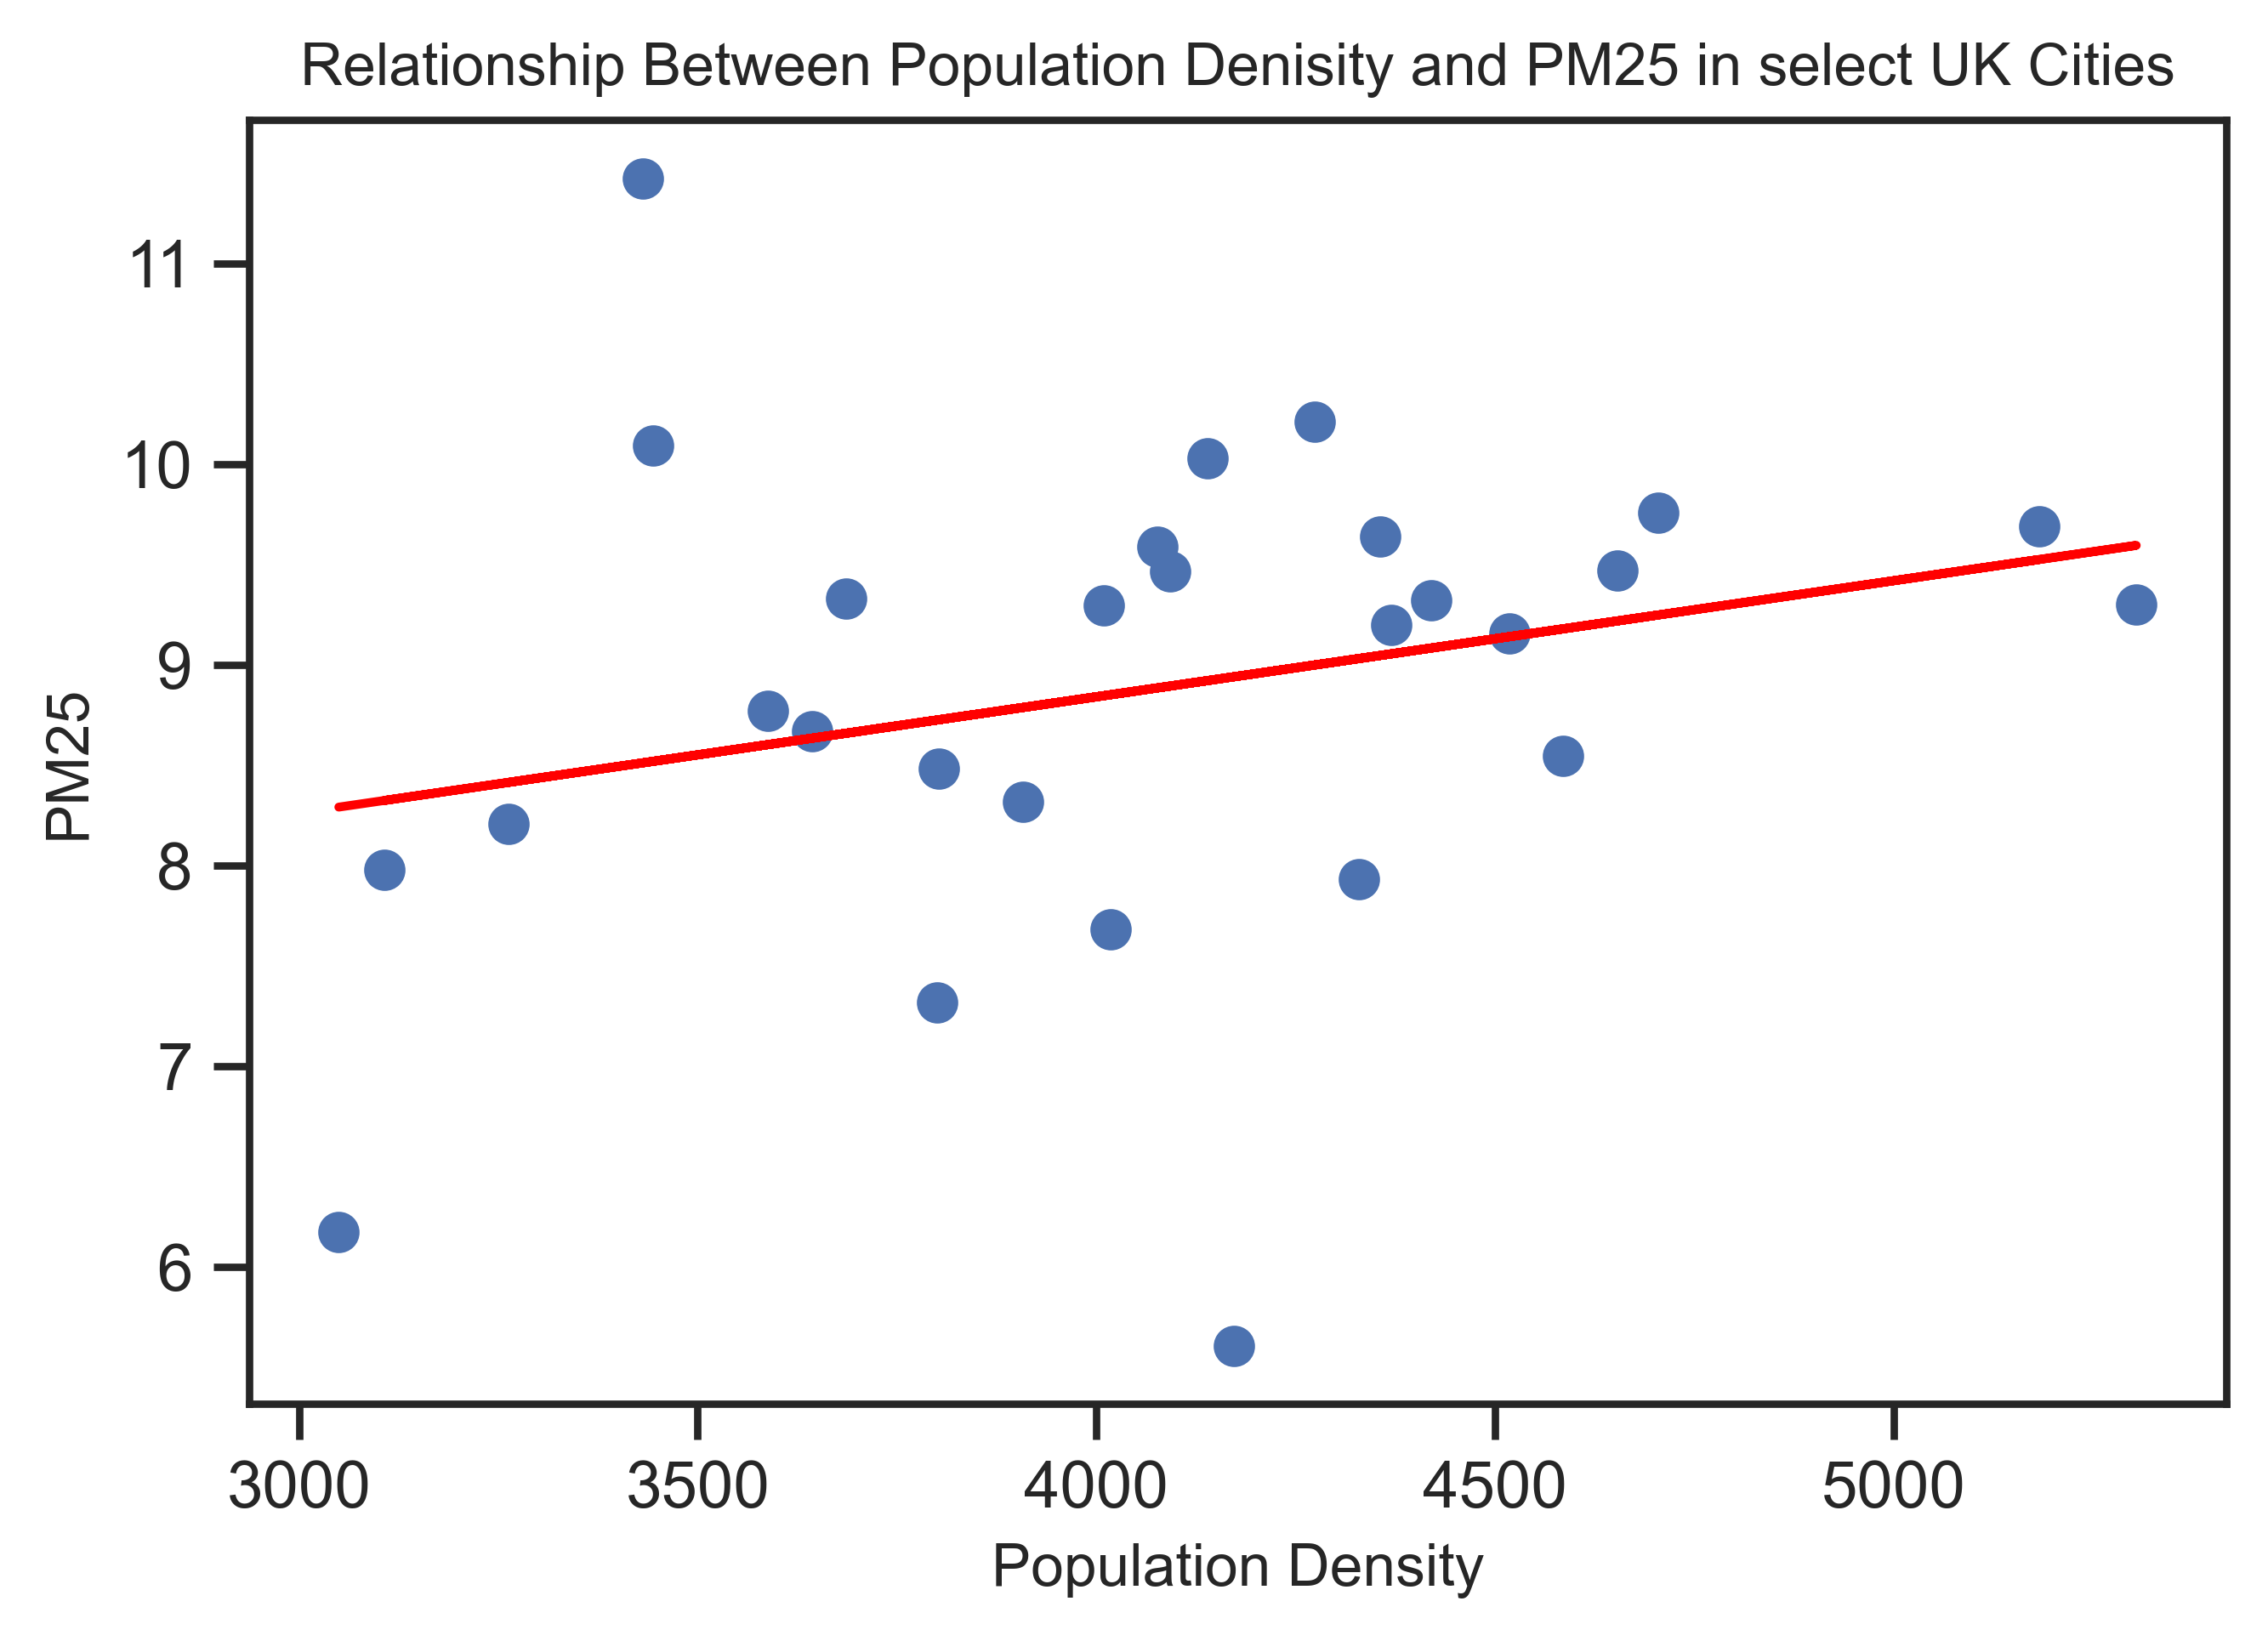

In [37]:
# plt.figure(figsize = (3,4))
plt.scatter(X, Y)
plt.plot(X, Y_pred, color = 'red')
plt.xlabel('Population Density',fontsize = 10)
plt.ylabel('PM25',fontsize = 10)
plt.title('Relationship Between Population Denisity and PM25 in select UK Cities',fontsize=10)
plt.show()

## IV. Conclusion

By analyzing the change of PM2.5 concentration during this period, we believe that the people and the government have attached great attention to air pollution in recent years and taken many measures to improve air quality, especially in the five-year plan implemented by the Beijing Ministry of Environmental Protection from 2013 to 2017, PM2.5 as one of the major atmospheric pollutants has been improved. The overall trend is decreasing year by year, and there is no apparent upward trend.

Moreover, we can find some factors correlate with the PM2.5 concentration. From the data set's of weather, the change in the average wind direction will obviously cause the change in the PM2.5 concentration, which is a negative correlation relationship. On the other hand, other variables could not prove to be closely related to PM2.5 concentration.  Supplementarily, PM2.5 concentration is positively correlated with population density in the UK case.

In addition, by observing the three maps above, we are sure that the PM2.5 concentration in Hebei Province has also improved. Importantly, the PM2.5 concentration of every city in Hebei Province is almost halved in 2021 compared to 2019. Furthermore, after analyzing the PM2.5 concentration in this local area, we believe that a large number of pollutants in Beijing are very likely to be transported from the southeast area through the air masses. They are mixed with the local pollutants to aggravate Beijing's air pollution. Therefore, the improvement of Beijing's air quality also depends on the emission and transmission of pollutants in the surrounding areas.